# Data Cleaning Notebook

## Objectives

- Identify and handle any missing or erroneous data.
- Use appropriate imputation methods for missing values.
- Split the data into training and test sets.

## Inputs

- `inputs/datasets/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv`

## Outputs

- Cleaned train and test datasets.
  - Path to the cleaned train set: `outputs/datasets/cleaned/TrainSetCleaned.csv`
  - Path to the cleaned test set: `outputs/datasets/cleaned/TestSetCleaned.csv`


---


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/ERA/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/ERA'

---

# Load Collected data

In [5]:
import pandas as pd

df = pd.read_csv("inputs/datasets/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


---

# Data Cleaning

From our exploratory data analysis, we identified certain columns with zero values that may not be accurate representations of the data. Specifically, MonthlyIncome and TotalWorkingYears contain zeros, which likely indicate missing or unrecorded information rather than valid data.

- MonthlyIncome: 19 zeros (1.3% of data)

- TotalWorkingYears: 11 zeros (0.7% of data)


Instead of removing these rows, we will treat the zero values as missing data (NaN) and impute them to preserve as much information as possible. We will replace zeros in these columns with the median value, which is less sensitive to outliers and better maintains the data's integrity.

In [6]:
import numpy as np

columns_to_check = ["MonthlyIncome", "TotalWorkingYears"]
for col in columns_to_check:
    df[col] = df[col].replace(0, np.nan)

# Function to evaluate missing data
def EvaluateMissingData(df):
    missing_data_absolute = df.isna().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data
    
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
TotalWorkingYears,11,0.75,float64


## Imputing Missing Values

Now, the NaN values can be replaced with imputed values.

- For numerical features like MonthlyIncome, we will use median imputation.

- For categorical variables like JobRole, we will use mode imputation.

In [7]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

pipeline = Pipeline([
    ("median_imputation", MeanMedianImputer(imputation_method="median",
                                            variables=["MonthlyIncome", "TotalWorkingYears"])),
    ("frequent_imputation", CategoricalImputer(imputation_method="frequent",
                                               variables=["JobRole", "MaritalStatus"]))
])

# Apply the pipeline to the data
cleaned_df = pipeline.fit_transform(df)

# Evaluate missing data after imputation
EvaluateMissingData(cleaned_df)


,RowsWithMissingData,PercentageOfDataset,DataType


## Assess the Effect of Data Cleaning

- Next we will visualize the distribution of cleaned features to ensure the cleaning process did not introduce bias.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['MonthlyIncome', 'TotalWorkingYears', 'JobRole', 'MaritalStatus'] 




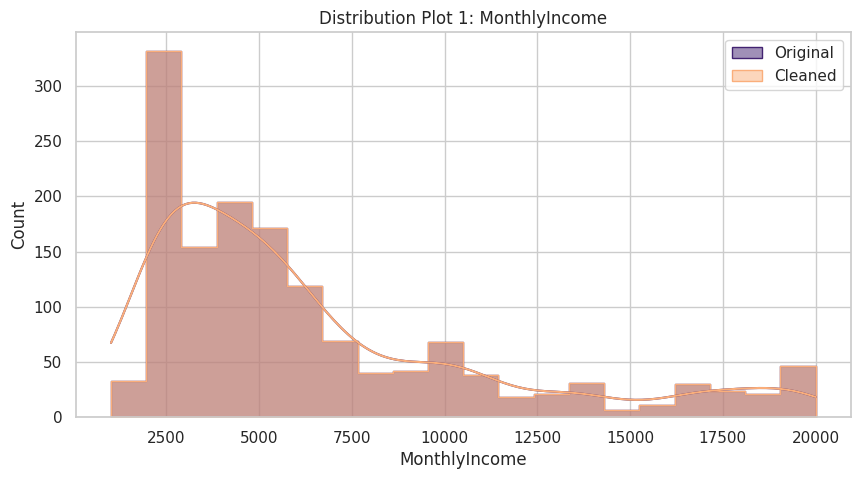

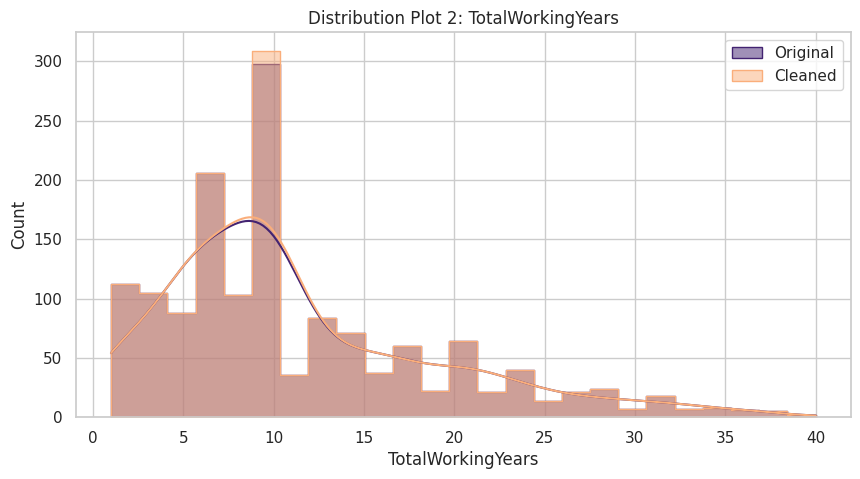

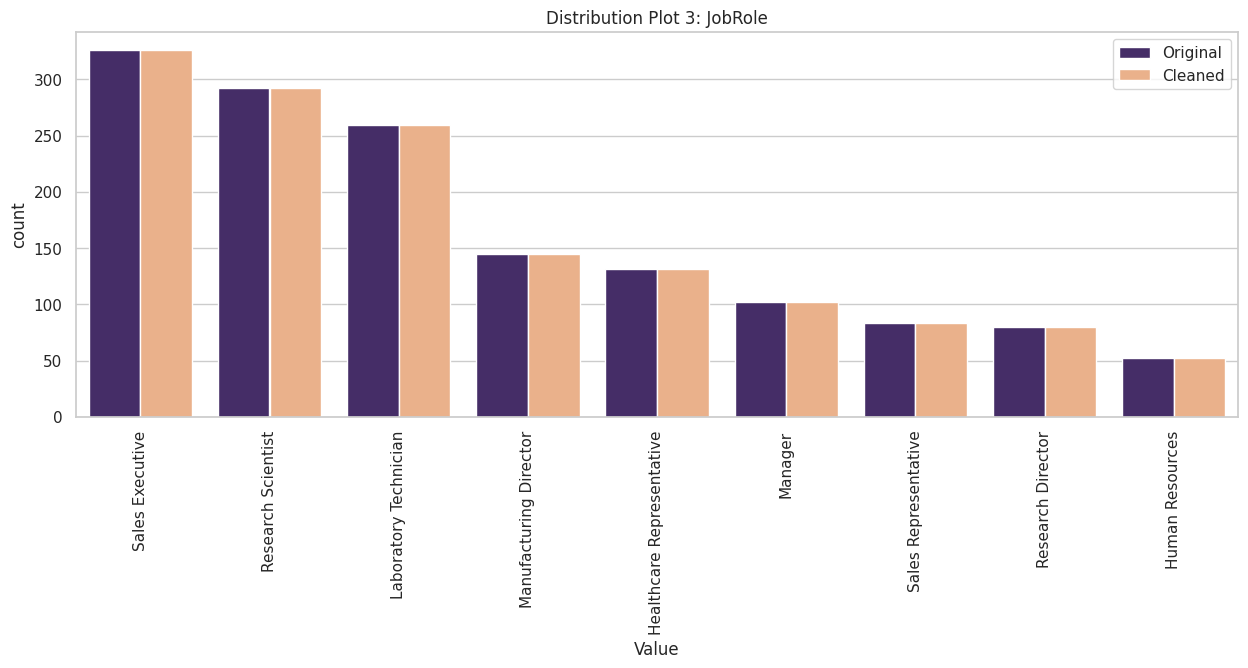

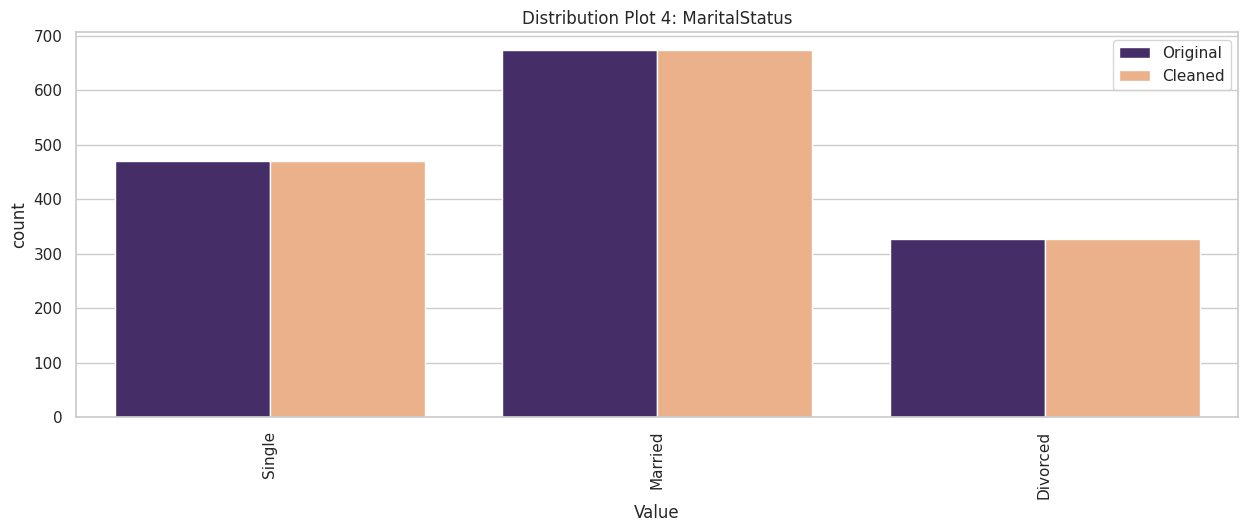

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

def DataCleaningEffect(df_original, df_cleaned, variables_applied_with_method):
    flag_count = 1
    categorical_variables = df_original.select_dtypes(exclude=['number']).columns

    for set_of_variables in [variables_applied_with_method]:
        print("\n=====================================================================================")
        print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
        print(f"{set_of_variables} \n\n")

        for var in set_of_variables:
            if var in categorical_variables:
                df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var]})
                df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var]})
                dfAux = pd.concat([df1, df2], axis=0)
                fig, axes = plt.subplots(figsize=(15, 5))
                sns.countplot(hue='Type', data=dfAux, x="Value", palette=["#432371", "#FAAE7B"])
                axes.set(title=f"Distribution Plot {flag_count}: {var}")
                plt.xticks(rotation=90)
                plt.legend()

            else:
                fig, axes = plt.subplots(figsize=(10, 5))
                sns.histplot(data=df_original, x=var, color="#432371", label="Original", kde=True, element="step", ax=axes)
                sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label="Cleaned", kde=True, element="step", ax=axes)
                axes.set(title=f"Distribution Plot {flag_count}: {var}")
                plt.legend()

            plt.show()
            flag_count += 1

cleaned_features = ["MonthlyIncome", "TotalWorkingYears", "JobRole", "MaritalStatus"]
DataCleaningEffect(df, cleaned_df, cleaned_features)


---

# Split into Training and Test Sets

In [9]:
from sklearn.model_selection import train_test_split

# Define target and features
X = cleaned_df.drop("Attrition", axis=1)
y = cleaned_df["Attrition"]

# Split the data into training and test sets
TrainSet, TestSet, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

TrainSet['Attrition'] = y_train
TestSet['Attrition'] = y_test

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")


TrainSet shape: (1176, 35) 
TestSet shape: (294, 35)


---

# Push files to Repo

In [10]:
os.makedirs('outputs/datasets/cleaned', exist_ok=True)

### Train Set

In [11]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

### Test Set

In [12]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)